In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt


In [2]:
seed = 43
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
batch_size = 64

In [4]:
def simple_tokenizer(text):
    return re.findall(r'\b\w+\b', str(text).lower())

In [5]:
train_df = pd.read_csv("Datasets/TrainData.csv")
test_df = pd.read_csv("Datasets/TestLabels.csv")

train_df.dropna(subset=['Text', 'Category'], inplace=True)
test_df.dropna(subset=['Text', 'Label - (business, tech, politics, sport, entertainment)'], inplace=True)

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

train_texts = train_df['Text'].tolist()
train_labels = train_df['Category'].tolist()
test_texts = test_df['Text'].tolist()
test_labels = test_df['Label - (business, tech, politics, sport, entertainment)'].tolist()

Train samples: 1490, Test samples: 735


In [6]:
train_tokenized = [simple_tokenizer(t) for t in train_texts]
test_tokenized = [simple_tokenizer(t) for t in test_texts]

In [7]:
lengths = [len(inner_array) for inner_array in train_tokenized]
max_len = int(np.percentile(lengths, 90))

In [8]:
class NewsDataset(Dataset):
    def __init__(self, tokenized_text, labels, vocab=None, label2idx=None, max_len=300):
        self.texts = tokenized_text
        self.max_len = max_len
        if vocab is None:
            words = [word for text in self.texts for word in text]
            word_freq = Counter(words)
            self.vocab = {'<PAD>': 0, '<UNK>': 1}
            for word in word_freq:
                self.vocab[word] = len(self.vocab)
        else:
            self.vocab = vocab

        self.texts = [self.encode(text) for text in self.texts]

        if label2idx is None:
            unique_labels = sorted(set(label for label in labels if pd.notna(label)))
            self.label2idx = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label2idx = label2idx

        self.labels = [self.label2idx[label] for label in labels if pd.notna(label)]

    def encode(self, tokens):
        encoded = [self.vocab.get(tok, self.vocab['<UNK>']) for tok in tokens]
        return encoded[:self.max_len] + [0]*(self.max_len - len(encoded))

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

In [9]:
train_data = NewsDataset(train_tokenized, train_labels)
test_data = NewsDataset(test_tokenized, test_labels, vocab=train_data.vocab, label2idx=train_data.label2idx)

In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [11]:
class TextTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_classes=5,
                 num_layers=4, num_heads=8, max_len=300, pos_embed=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.pos_embed_enabled = pos_embed
        
        # Embedding layers
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        if pos_embed:
            self.position_embedding = nn.Embedding(max_len, embed_dim)
        
        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=0.1,
            activation="gelu"
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification layer
        self.classifier = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        positions = torch.arange(0, x.size(1), dtype=torch.long).unsqueeze(0).to(device)
        
        x_embed = self.word_embedding(x)
        if self.pos_embed_enabled:
            x_embed += self.position_embedding(positions)
        
        x_transformed = self.transformer_encoder(x_embed)
        x_pooled = x_transformed.mean(dim=1)  # Mean pooling across sequence length
        
        return self.classifier(x_pooled)



In [12]:
def evaluate_model(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    all_preds ,all_labels = [] ,[]
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(y_batch.cpu().tolist())

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels,all_preds,average='micro')
    return avg_loss, accuracy,f1

In [13]:
def train_model(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    return avg_train_loss , train_accuracy

In [14]:
EPOCHS = 50
lr = 0.0003
weight_decay = 1e-3

In [15]:
model_params = {
    "vocab_size": len(train_data.vocab),
    "embed_dim": 512,
    "num_classes": len(train_data.label2idx),
    "num_layers": 1,
    "num_heads": 8,
    "max_len": max_len,
    "pos_embed": True
}

model = TextTransformer(**model_params).to(device)


c:\Users\kashp\miniconda3\envs\dla3\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0002)




Analyzing Encoder Blocks...

=== Training with 2 encoder blocks ===


c:\Users\kashp\miniconda3\envs\dla3\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 | Train Loss: 1.5667 | Val F1: 0.2844
Epoch 2/50 | Train Loss: 1.4945 | Val F1: 0.3633
Epoch 3/50 | Train Loss: 1.3243 | Val F1: 0.4599
Epoch 4/50 | Train Loss: 1.0738 | Val F1: 0.6993
Epoch 5/50 | Train Loss: 0.8217 | Val F1: 0.7143
Epoch 6/50 | Train Loss: 0.6669 | Val F1: 0.7252
Epoch 7/50 | Train Loss: 0.5451 | Val F1: 0.8435
Epoch 8/50 | Train Loss: 0.4401 | Val F1: 0.8095
Epoch 9/50 | Train Loss: 0.3662 | Val F1: 0.8544
Epoch 10/50 | Train Loss: 0.2934 | Val F1: 0.8503
Epoch 11/50 | Train Loss: 0.2503 | Val F1: 0.8694
Epoch 12/50 | Train Loss: 0.2134 | Val F1: 0.8558
Epoch 13/50 | Train Loss: 0.1684 | Val F1: 0.8844
Epoch 14/50 | Train Loss: 0.1354 | Val F1: 0.9102
Epoch 15/50 | Train Loss: 0.1116 | Val F1: 0.9007
Epoch 16/50 | Train Loss: 0.0956 | Val F1: 0.9061
Epoch 17/50 | Train Loss: 0.0861 | Val F1: 0.9007
Epoch 18/50 | Train Loss: 0.0750 | Val F1: 0.9075
Epoch 19/50 | Train Loss: 0.0609 | Val F1: 0.8952
Epoch 20/50 | Train Loss: 0.0524 | Val F1: 0.9143
Epoch 21/

c:\Users\kashp\miniconda3\envs\dla3\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 | Train Loss: 1.5818 | Val F1: 0.2803
Epoch 2/50 | Train Loss: 1.4821 | Val F1: 0.4367
Epoch 3/50 | Train Loss: 1.3442 | Val F1: 0.4626
Epoch 4/50 | Train Loss: 1.1034 | Val F1: 0.6803
Epoch 5/50 | Train Loss: 0.9054 | Val F1: 0.7224
Epoch 6/50 | Train Loss: 0.7078 | Val F1: 0.7946
Epoch 7/50 | Train Loss: 0.5783 | Val F1: 0.8041
Epoch 8/50 | Train Loss: 0.4521 | Val F1: 0.8612
Epoch 9/50 | Train Loss: 0.3507 | Val F1: 0.8558
Epoch 10/50 | Train Loss: 0.2869 | Val F1: 0.8639
Epoch 11/50 | Train Loss: 0.2271 | Val F1: 0.8762
Epoch 12/50 | Train Loss: 0.1966 | Val F1: 0.8571
Epoch 13/50 | Train Loss: 0.1592 | Val F1: 0.8952
Epoch 14/50 | Train Loss: 0.1300 | Val F1: 0.8748
Epoch 15/50 | Train Loss: 0.1015 | Val F1: 0.8925
Epoch 16/50 | Train Loss: 0.0876 | Val F1: 0.9102
Epoch 17/50 | Train Loss: 0.0725 | Val F1: 0.8980
Epoch 18/50 | Train Loss: 0.0604 | Val F1: 0.9102
Epoch 19/50 | Train Loss: 0.0465 | Val F1: 0.9293
Epoch 20/50 | Train Loss: 0.0429 | Val F1: 0.9170
Epoch 21/

c:\Users\kashp\miniconda3\envs\dla3\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 | Train Loss: 1.5821 | Val F1: 0.2857
Epoch 2/50 | Train Loss: 1.5027 | Val F1: 0.3959
Epoch 3/50 | Train Loss: 1.3321 | Val F1: 0.4000
Epoch 4/50 | Train Loss: 1.2277 | Val F1: 0.4327
Epoch 5/50 | Train Loss: 1.0694 | Val F1: 0.5007
Epoch 6/50 | Train Loss: 0.9389 | Val F1: 0.6748
Epoch 7/50 | Train Loss: 0.8280 | Val F1: 0.7483
Epoch 8/50 | Train Loss: 0.6806 | Val F1: 0.8218
Epoch 9/50 | Train Loss: 0.5509 | Val F1: 0.8177
Epoch 10/50 | Train Loss: 0.4622 | Val F1: 0.7483
Epoch 11/50 | Train Loss: 0.4006 | Val F1: 0.8639
Epoch 12/50 | Train Loss: 0.3069 | Val F1: 0.8395
Epoch 13/50 | Train Loss: 0.2545 | Val F1: 0.8721
Epoch 14/50 | Train Loss: 0.2207 | Val F1: 0.9007
Epoch 15/50 | Train Loss: 0.1781 | Val F1: 0.8884
Epoch 16/50 | Train Loss: 0.1571 | Val F1: 0.9088
Epoch 17/50 | Train Loss: 0.1340 | Val F1: 0.8571
Epoch 18/50 | Train Loss: 0.1098 | Val F1: 0.9075
Epoch 19/50 | Train Loss: 0.0816 | Val F1: 0.9224
Epoch 20/50 | Train Loss: 0.0607 | Val F1: 0.9170
Epoch 21/

c:\Users\kashp\miniconda3\envs\dla3\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 | Train Loss: 1.5547 | Val F1: 0.2490
Epoch 2/50 | Train Loss: 1.4691 | Val F1: 0.4218
Epoch 3/50 | Train Loss: 1.3224 | Val F1: 0.3429
Epoch 4/50 | Train Loss: 1.1459 | Val F1: 0.6517
Epoch 5/50 | Train Loss: 0.9198 | Val F1: 0.6612
Epoch 6/50 | Train Loss: 0.7057 | Val F1: 0.7946
Epoch 7/50 | Train Loss: 0.5279 | Val F1: 0.8585
Epoch 8/50 | Train Loss: 0.4115 | Val F1: 0.8694
Epoch 9/50 | Train Loss: 0.3100 | Val F1: 0.8816
Epoch 10/50 | Train Loss: 0.2519 | Val F1: 0.8639
Epoch 11/50 | Train Loss: 0.2081 | Val F1: 0.8571
Epoch 12/50 | Train Loss: 0.1762 | Val F1: 0.9088
Epoch 13/50 | Train Loss: 0.1411 | Val F1: 0.9088
Epoch 14/50 | Train Loss: 0.1176 | Val F1: 0.8816
Epoch 15/50 | Train Loss: 0.0998 | Val F1: 0.8871
Epoch 16/50 | Train Loss: 0.0832 | Val F1: 0.9156
Epoch 17/50 | Train Loss: 0.0719 | Val F1: 0.8884
Epoch 18/50 | Train Loss: 0.0580 | Val F1: 0.9184
Epoch 19/50 | Train Loss: 0.0505 | Val F1: 0.9102
Epoch 20/50 | Train Loss: 0.0438 | Val F1: 0.9184
Epoch 21/

c:\Users\kashp\miniconda3\envs\dla3\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 | Train Loss: 1.5310 | Val F1: 0.4735
Epoch 2/50 | Train Loss: 1.3746 | Val F1: 0.4707
Epoch 3/50 | Train Loss: 1.0452 | Val F1: 0.7333
Epoch 4/50 | Train Loss: 0.6977 | Val F1: 0.8272
Epoch 5/50 | Train Loss: 0.4838 | Val F1: 0.8340
Epoch 6/50 | Train Loss: 0.3825 | Val F1: 0.8857
Epoch 7/50 | Train Loss: 0.2967 | Val F1: 0.9075
Epoch 8/50 | Train Loss: 0.2390 | Val F1: 0.9088
Epoch 9/50 | Train Loss: 0.1932 | Val F1: 0.9388
Epoch 10/50 | Train Loss: 0.1561 | Val F1: 0.9265
Epoch 11/50 | Train Loss: 0.1275 | Val F1: 0.9333
Epoch 12/50 | Train Loss: 0.1155 | Val F1: 0.9374
Epoch 13/50 | Train Loss: 0.0978 | Val F1: 0.9333
Epoch 14/50 | Train Loss: 0.0872 | Val F1: 0.9293
Epoch 15/50 | Train Loss: 0.0757 | Val F1: 0.9401
Epoch 16/50 | Train Loss: 0.0641 | Val F1: 0.9442
Epoch 17/50 | Train Loss: 0.0536 | Val F1: 0.9469
Epoch 18/50 | Train Loss: 0.0488 | Val F1: 0.9401
Epoch 19/50 | Train Loss: 0.0418 | Val F1: 0.9401
Epoch 20/50 | Train Loss: 0.0421 | Val F1: 0.9415
Epoch 21/

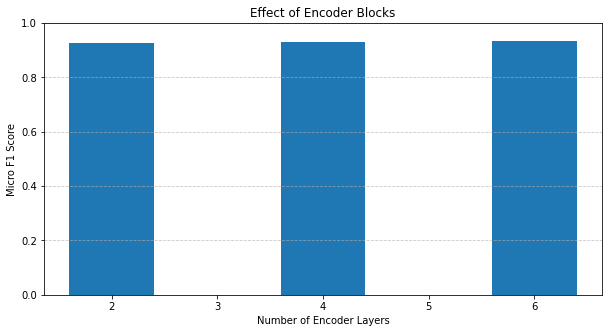

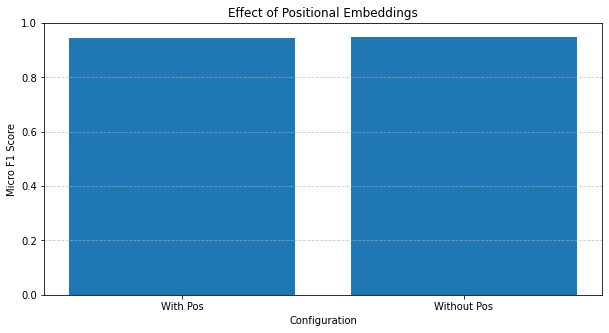

In [22]:
patience = 15 
def analyze_encoder_blocks():
    """Analyze performance with different numbers of encoder blocks"""
    encoder_results = {}
    
    for num_layers in [2, 4, 6]:
        print(f"\n=== Training with {num_layers} encoder blocks ===")
        
        # Model configuration
        model_params = {
            "vocab_size": len(train_data.vocab),
            "embed_dim": 512,
            "num_classes": len(train_data.label2idx),
            "num_layers": num_layers,
            "num_heads": 8,
            "max_len": max_len,
            "pos_embed": True
        }
        
        # Initialize fresh model
        model = TextTransformer(**model_params).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.0002)
        
        best_f1 = 0
        patience_counter = 0
        
        for epoch in range(EPOCHS):
            avg_train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
            avg_val_loss, val_acc, val_f1 = evaluate_model(model, test_loader, criterion)
            
            print(f"Epoch {epoch+1}/{EPOCHS} | "
                  f"Train Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f}")
            
            # Early stopping
            if val_f1 > best_f1:
                best_f1 = val_f1
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                break
                
        encoder_results[num_layers] = best_f1
    
    return encoder_results

def analyze_positional_embeddings():
    """Analyze performance with/without positional embeddings"""
    pos_results = {}
    
    for use_pos in [True, False]:
        print(f"\n=== Training {'with' if use_pos else 'without'} positional embeddings ===")
        
        # Model configuration
        model_params = {
            "vocab_size": len(train_data.vocab),
            "embed_dim": 512,
            "num_classes": len(train_data.label2idx),
            "num_layers": 2,  # Default layer count
            "num_heads": 8,
            "max_len": max_len,
            "pos_embed": use_pos
        }
        
        # Initialize fresh model
        model = TextTransformer(**model_params).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.0002)
        
        best_f1 = 0
        patience_counter = 0
        
        for epoch in range(EPOCHS):
            avg_train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
            avg_val_loss, val_acc, val_f1 = evaluate_model(model, test_loader, criterion)
            
            print(f"Epoch {epoch+1}/{EPOCHS} | "
                  f"Train Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f}")
            
            # Early stopping
            if val_f1 > best_f1:
                best_f1 = val_f1
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                break
                
        pos_results['With Pos' if use_pos else 'Without Pos'] = best_f1
    
    return pos_results

# Add this visualization function
def plot_results(results, title, xlabel):
    plt.figure(figsize=(10, 5))
    plt.bar(results.keys(), results.values())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Micro F1 Score")
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Run analyses after your single model training
print("\n" + "="*50)
print("Analyzing Encoder Blocks...")
encoder_results = analyze_encoder_blocks()
print("\nEncoder Block Results:")
for layers, f1 in encoder_results.items():
    print(f"{layers} layers: F1 = {f1:.4f}")

print("\n" + "="*50)
print("Analyzing Positional Embeddings...")
pos_results = analyze_positional_embeddings()
print("\nPositional Embedding Results:")
for config, f1 in pos_results.items():
    print(f"{config}: F1 = {f1:.4f}")

# Plot results
plot_results(encoder_results, "Effect of Encoder Blocks", "Number of Encoder Layers")
plot_results(pos_results, "Effect of Positional Embeddings", "Configuration")


In [17]:
patience = 15 
best_val_loss = float('inf')
counter = 0  
for epoch in range(EPOCHS):
    avg_train_loss , train_accuracy = train_model(model, train_loader, criterion, optimizer)
    avg_val_loss, val_accuracy ,f1 = evaluate_model(model, test_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | f1: {f1:.2f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0 
        best_model = model.state_dict()  
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch}. Best val loss: {best_val_loss:.4f}")
        break

Epoch 1/50 | Train Loss: 1.5530 | Train Acc: 26.78% | Val Loss: 1.4968 | Val Acc: 29.66% | f1: 0.30
Epoch 2/50 | Train Loss: 1.4887 | Train Acc: 34.43% | Val Loss: 1.4190 | Val Acc: 50.88% | f1: 0.51
Epoch 3/50 | Train Loss: 1.3480 | Train Acc: 44.43% | Val Loss: 1.2516 | Val Acc: 51.97% | f1: 0.52
Epoch 4/50 | Train Loss: 1.1645 | Train Acc: 58.26% | Val Loss: 1.0561 | Val Acc: 67.35% | f1: 0.67
Epoch 5/50 | Train Loss: 0.9214 | Train Acc: 72.48% | Val Loss: 0.8455 | Val Acc: 76.87% | f1: 0.77
Epoch 6/50 | Train Loss: 0.7367 | Train Acc: 80.74% | Val Loss: 0.7231 | Val Acc: 82.86% | f1: 0.83
Epoch 7/50 | Train Loss: 0.5636 | Train Acc: 90.67% | Val Loss: 0.6065 | Val Acc: 86.26% | f1: 0.86
Epoch 8/50 | Train Loss: 0.4427 | Train Acc: 93.09% | Val Loss: 0.5331 | Val Acc: 88.44% | f1: 0.88
Epoch 9/50 | Train Loss: 0.3702 | Train Acc: 93.83% | Val Loss: 0.4828 | Val Acc: 88.57% | f1: 0.89
Epoch 10/50 | Train Loss: 0.2868 | Train Acc: 97.32% | Val Loss: 0.4956 | Val Acc: 84.49% | f1: 0.84

In [20]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [21]:
# Final evaluation and confusion matrix
avg_val_loss, val_accuracy, f1 = evaluate_model(model, test_loader, criterion)
print(f"\nFinal Micro F1 Score = {f1:.4f}")
label_names = [label for label, _ in sorted(train_data.label2idx.items(), key=lambda x: x[1])]



Final Micro F1 Score = 0.9279
